In [2]:
# Packages
import nfl_data_py as nfl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


In [ ]:
# Load the data
pbp = nfl.import_pbp_data(range(2020, 2025))
pbp.head(10)

2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type,old_game_id
0,1.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,None,None,None,...,,0.0,0.0,NaN,NaN,NaN,None,None,None,NaN
1,39.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,00-0034073;00-0034730;00-0033783;00-0031961;00...,11.0,11.0,NaN,NaN,NaN,None,None,None,NaN
2,54.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0,4.19,2.436,0.0,OUT,MAN_COVERAGE,COVER_1,NaN
3,93.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0,NaN,NaN,NaN,None,None,None,NaN
4,118.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,00-0029585;00-0035236;00-0031557;00-0029747;00...,11.0,11.0,NaN,NaN,NaN,None,None,None,NaN
5,143.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,00-0029585;00-0035236;00-0029747;00-0027686;00...,11.0,11.0,NaN,NaN,NaN,None,None,None,NaN
6,165.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,00-0029560;00-0029585;00-0035236;00-0029747;00...,11.0,11.0,9.17,2.201,0.0,HITCH,ZONE_COVERAGE,COVER_3,NaN
7,197.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,00-0034490;00-0031557;00-0035248;00-0029747;00...,11.0,11.0,NaN,NaN,NaN,None,None,None,NaN
8,226.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,ARI,away,SF,...,00-0034681;00-0033258;00-0034490;00-0029747;00...,11.0,11.0,NaN,NaN,NaN,None,None,None,NaN
9,245.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,ARI,away,SF,...,00-0032057;00-0035717;00-0033870;00-0032164;00...,11.0,11.0,4.08,1.835,0.0,OUT,ZONE_COVERAGE,COVER_4,NaN


In [4]:
# Filter to dropbacks only
dropbacks = pbp[pbp['qb_dropback'] == 1].copy()

# Calculate defensive skill metrics per defense per season
def_metrics = (
    dropbacks.groupby(['season', 'defteam'])
    .agg(
        def_epa_per_dropback=('epa', 'mean'),
        def_success_rate_allowed=('success', 'mean'),
        def_pressure_rate=('qb_hit', 'sum'),
        def_dropbacks=('qb_dropback', 'count'),
    )
    .assign(def_pressure_rate=lambda df: df.def_pressure_rate / df.def_dropbacks)
    .reset_index()
)

# Calculate OL proxy metrics per offense per season
ol_metrics = (
    dropbacks.groupby(['season', 'posteam'])
    .agg(
        pressures_allowed=('qb_hit', 'sum'),
        sacks_allowed=('sack', 'sum'),
        dropbacks=('qb_dropback', 'count'),
    )
    .assign(
        pressure_rate=lambda df: df.pressures_allowed / df.dropbacks,
        sack_rate=lambda df: df.sacks_allowed / df.dropbacks
    )
    .reset_index()
)

# Merge defensive and OL metrics onto dropbacks
dropbacks = dropbacks.merge(def_metrics, on=['season', 'defteam'], how='left')
dropbacks = dropbacks.merge(ol_metrics, on=['season', 'posteam'], how='left')

# Filter for true QBs with min dropbacks threshold
min_dropbacks = 150
qb_counts = dropbacks.groupby(['season', 'passer_player_name']).size().reset_index(name='dropbacks')
true_qbs = qb_counts[qb_counts['dropbacks'] >= min_dropbacks]['passer_player_name'].unique()
dropbacks_true_qbs = dropbacks[dropbacks['passer_player_name'].isin(true_qbs)].copy()

# Define clutch situations: 3rd/4th and long, last 5 minutes, close game (within 7 points)
dropbacks_true_qbs['clutch_situation'] = (
    (dropbacks_true_qbs['down'].isin([3, 4])) &
    (dropbacks_true_qbs['ydstogo'] >= 7) &
    (dropbacks_true_qbs['game_seconds_remaining'] <= 300) &
    (dropbacks_true_qbs['score_differential'].abs() <= 7)
)

# Add play-level adjusted EPA
dropbacks_true_qbs['adj_epa'] = (
    dropbacks_true_qbs['epa'] - dropbacks_true_qbs['def_epa_per_dropback']
) / (1 + dropbacks_true_qbs['pressure_rate'])

# Aggregate clutch adjusted EPA stats per QB
clutch_stats = (
    dropbacks_true_qbs[dropbacks_true_qbs['clutch_situation']]
    .groupby('passer_player_name')['adj_epa']
    .agg(['mean', 'sum', 'count'])
    .rename(columns={
        'mean': 'clutch_avg_adj_epa',
        'sum': 'clutch_total_adj_epa',
        'count': 'clutch_plays'
    })
    .reset_index()
)

# Aggregate non-clutch adjusted EPA stats per QB
non_clutch_stats = (
    dropbacks_true_qbs[~dropbacks_true_qbs['clutch_situation']]
    .groupby('passer_player_name')['adj_epa']
    .agg(['mean', 'sum', 'count'])
    .rename(columns={
        'mean': 'non_clutch_avg_adj_epa',
        'sum': 'non_clutch_total_adj_epa',
        'count': 'non_clutch_plays'
    })
    .reset_index()
)

# Aggregate overall QB metrics normalized by defense and OL skill
qb_adj = (
    dropbacks_true_qbs.groupby(['season', 'passer_player_name'])
    .agg(
        dropbacks=('qb_dropback', 'count'),
        total_epa=('epa', 'sum'),
        avg_epa_per_dropback=('epa', 'mean'),
        avg_def_epa_allowed=('def_epa_per_dropback', 'mean'),
        avg_def_success_rate_allowed=('def_success_rate_allowed', 'mean'),
        avg_def_pressure_rate=('def_pressure_rate', 'mean'),
        avg_ol_pressure_rate_allowed=('pressure_rate', 'mean'),
        avg_ol_sack_rate_allowed=('sack_rate', 'mean'),
    )
    .reset_index()
)

# Merge clutch stats with overall QB summary
qb_adj = qb_adj.merge(clutch_stats, on='passer_player_name', how='left')
qb_adj = qb_adj.merge(non_clutch_stats, on='passer_player_name', how='left')

# Calculate adjusted EPA metrics
qb_adj['epa_vs_expectation'] = qb_adj['avg_epa_per_dropback'] - qb_adj['avg_def_epa_allowed']
qb_adj['epa_vs_def_and_ol'] = qb_adj['epa_vs_expectation'] / (1 + qb_adj['avg_ol_pressure_rate_allowed'])

# Calculate clutch vs non-clutch adjusted EPA difference
qb_adj['clutch_vs_non_clutch_adj_diff'] = qb_adj['clutch_avg_adj_epa'] - qb_adj['non_clutch_avg_adj_epa']

# Filter to just QBs with over 200 dropbacks
qb_adj = qb_adj[qb_adj['dropbacks'] >= 200].copy()

qb_adj.head(10)


,season,passer_player_name,dropbacks,total_epa,avg_epa_per_dropback,avg_def_epa_allowed,avg_def_success_rate_allowed,avg_def_pressure_rate,avg_ol_pressure_rate_allowed,avg_ol_sack_rate_allowed,clutch_avg_adj_epa,clutch_total_adj_epa,clutch_plays,non_clutch_avg_adj_epa,non_clutch_total_adj_epa,non_clutch_plays,epa_vs_expectation,epa_vs_def_and_ol,clutch_vs_non_clutch_adj_diff
0,2020,A.Dalton,357,-15.207176,-0.042597,0.042460,0.469935,0.149414,0.132768,0.062147,-0.262139,-3.145671,12.0,-0.080141,-98.893380,1234,-0.085057,-0.075088,-0.181999
1,2020,A.Rodgers,634,195.302170,0.308048,0.099488,0.485396,0.133313,0.087746,0.039334,-0.513855,-10.277098,20.0,0.057710,123.383423,2138,0.208560,0.191736,-0.571565
2,2020,A.Smith,274,-37.050831,-0.135222,0.075793,0.471843,0.145804,0.157459,0.071823,-0.232869,-1.164343,5.0,-0.181369,-48.788186,269,-0.211015,-0.182309,-0.051500
3,2020,B.Mayfield,580,88.259171,0.152171,0.067905,0.470964,0.149943,0.088424,0.043408,-0.478491,-11.005298,23.0,0.028807,78.239811,2716,0.084266,0.077420,-0.507298
4,2020,B.Roethlisberger,696,52.284470,0.075121,0.097093,0.480352,0.134083,0.097333,0.018667,0.158771,2.857882,18.0,-0.069869,-95.720612,1370,-0.021972,-0.020023,0.228640
5,2020,C.Newton,398,-22.420835,-0.056334,0.089750,0.483444,0.138410,0.154309,0.074148,-0.158021,-0.790103,5.0,-0.162761,-86.263504,530,-0.146084,-0.126555,0.004741
6,2020,C.Wentz,492,-82.573616,-0.167833,0.030404,0.461321,0.146946,0.193863,0.090656,0.653237,7.185612,11.0,-0.106762,-148.612131,1392,-0.198236,-0.166046,0.759999
7,2020,D.Brees,475,51.384773,0.108178,0.087929,0.472518,0.135634,0.128682,0.046512,NaN,NaN,NaN,0.017941,8.521829,475,0.020249,0.017941,NaN
8,2020,D.Carr,540,42.028336,0.077830,0.065135,0.475666,0.137613,0.089552,0.046434,0.061448,1.843440,30.0,0.010131,26.696278,2635,0.012695,0.011652,0.051317
9,2020,D.Haskins,262,-44.358089,-0.169306,0.074130,0.471011,0.145264,0.157459,0.071823,-0.284758,-1.139032,4.0,-0.209165,-53.964521,258,-0.243435,-0.210319,-0.075593


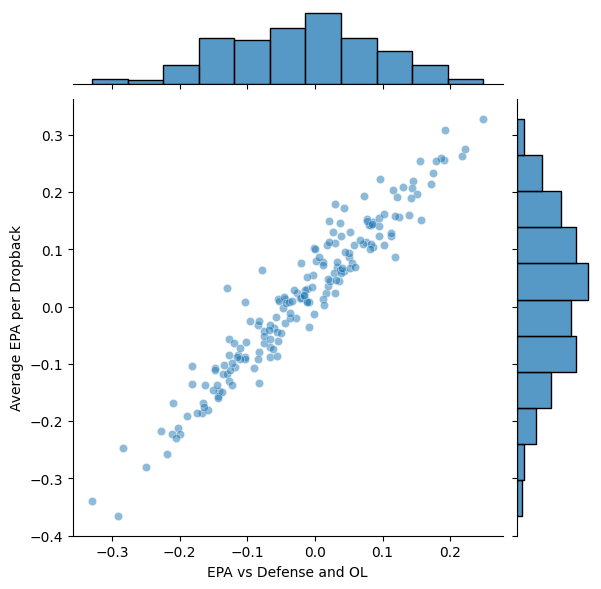

In [9]:
### Explore qb data ###
# Plot distribution of epa_vs_def_and_ol and epa_per_dropback
sns.jointplot(
    data=qb_adj,
    x='epa_vs_def_and_ol',
    y='avg_epa_per_dropback',
    kind='scatter',
    alpha=0.5,
)
plt.xlabel('EPA vs Defense and OL')
plt.ylabel('Average EPA per Dropback')
plt.show()
